# IML Project - Report Notebook
---
Project by:
- benoist.andre
- erwann.harris
- ihor.husak
- melanie.tcheou

You can find the video presentation [**here**](https://www.youtube.com/watch?v=ql-q-biGUlU) __**#FIXME(Change link)**__

Who did what?

|                            | Benoist | Erwann | Ihor | Mélanie |
|----------------------------|---------|--------|------|---------|
| Dummy Baseline             |         |        |      | ✅       |
| Simple Shape Extractor     |         |        | ✅    |         |
| Image Moments              |         |        |      | ✅       |
| Color Histograms           |         | ✅      |      |         |
| Feature Extractor Research (ORB) |         | ✅      |      |         |
| Feature Fusion             |         |        |      | ✅       |
| Classifier Research        | ✅       |        | ✅    |       |
| Classifier Evaluation      | ✅       |        |      |         |

### Table of Contents

- [**Evaluation Tools**](#Tools)
- [**The Dummy Baseline**](#Dummy)
- [**Feature Extractors**](#FT)
    - [**Simple Shape Extractor**](#Shape)
        - [Evaluating the results](#ShapeEval)
    - [**Image Moments**](#ImageMoments)
        - [Raw Moments](#ImageMomentsRaw)
        - [Central Moments](#ImageMomentsCentral)
        - [Central Normalized Moments](#ImageMomentsNormalized)
        - [Hu Invariants](#ImageMomentsHu)
        - [Evaluating the results : The importance of normalizing the data](#ImageMomentsEval)

    - [**Color Histograms**](#ColorHistograms)
        - [Evaluating the results](#ColorHistogramsEval)
- [**Improving the results : Feature Fusion**](#Improve)
- [**Evaluating and comparing the results**](#Evaluate)
- [**Results Analysis**](#Results)
- [**Conclusion**](#Conclusion)

In [30]:
# Basic imports
import numpy as np
import os
import cv2
import math
import random
import matplotlib.pyplot as plt

#Used for color histogram
from scipy import ndimage as ndi
from scipy.spatial.distance import euclidean, cosine
from skimage import filters
from sklearn.cluster import KMeans

random.seed(10)

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import RidgeClassifier
from sklearn.neural_network import MLPClassifier
import numpy as np
import random
from matplotlib import pyplot as plt
from skimage import io, measure, filters, segmentation, feature, morphology
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
from scipy import ndimage as ndi
import cv2
from sklearn.metrics import f1_score

import joblib

In [31]:
trainpath = 'trainset/train'

## Evaluation Tools <a class="anchor" id="Tools"></a>
The following functions will be useful to simply evaluate our different feature extractors.


In [32]:
def get_imgs_paths(
        data_dir):  # Gets full paths for all images in the trainset, and splits it into train et test datasets.
    xtrain, ytrain, xtest, ytest = [], [], [], []

    for label in os.listdir(data_dir):
        dirpath = os.path.join(data_dir, label)
        imgs_paths = os.listdir(dirpath)
        itest = random.randint(0,
                               4)  # As we have 5 images per category, we want to use 4 for training, and keep 1 for testing.

        for i in range(len(imgs_paths)):
            impath = os.path.join(dirpath, imgs_paths[i])
            if i != itest:
                xtrain.append(impath)
                ytrain.append(label)
            else:
                xtest.append(impath)
                ytest.append(label)

    return xtrain, ytrain, xtest, ytest


def get_data(xpaths, feature_extractor):  # Computes the given feature for each path in the given paths list.
    xdata = []
    for path in xpaths:
        feature = feature_extractor(path)
        xdata.append(feature)
    return np.array(xdata)

In [33]:
def my_test(xtrain, ytrain, test_input, test_expected, clf=RandomForestClassifier(), return_res=False):
    clf.fit(xtrain, ytrain)

    false = 0
    preds = []
    for i in range(len(test_input)):
        res = clf.predict(test_input[i].reshape(1, -1))[0]
        if res != test_expected[i]:
            false += 1
        preds.append(res)

    print("{:<20}% success".format((1 - false / len(test_input)) * 100))
    if return_res: return preds

To test the feature extractors, we will be using the same dataset which will be the following :

In [34]:
xtrainpaths, ytrain, xtestpaths, ytest = get_imgs_paths(trainpath)

## The Dummy Baseline<a class="anchor" id="Dummy"></a>
The first step was to create a dummy baseline that would guess a class at random that would be our base for evaluation.

In [35]:
class random_clf:  # To represent the random classifier, aka the dummy implementation
    def fit(xtrain, ytrain):
        return

    def predict(input_):
        return [random.randint(1, 57)]

In [36]:
def tmp_get_data(xpaths):  # Computes the given feature for each path in the given paths list.
    xdata = []
    for path in xpaths:
        img = cv2.imread(path)
        xdata.append(img)
    return np.array(xdata)


my_test(tmp_get_data(xtrainpaths), ytrain, tmp_get_data(xtestpaths), ytest, clf=random_clf)

0.0                 % success


C:\Users\Administrateur\AppData\Local\Temp\ipykernel_6512\2603109664.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(xdata)


Quite obviously, the restults are far from good. We thus have to find another way to improve our predictions. We shall try different feature extraction methods, and figure which ones are best suited four our problem.

## Feature Extractors<a class="anchor" id="FT"></a>

## Simple shape extractor <a class="anchor" id="Shape"></a>
A basic way to describe an image would be by the shape of its content. To extract this shape, we use a Sobel filter on the image to get its edges, 
followed by a binary fill to fill the shape.

This shape extracting technique probably is too simple and we predict that it will not be scale and orientation resistant if we feed the data as is into the classifier.

In [37]:
def extract_shape(image):
    sobel = filters.sobel(image)
    res = ndi.binary_fill_holes(sobel)
    return res

The issue with this technique is that the resulting array shape depends on the input image. To pass it through a classifier, we need to resize it, to make the images the same size.

In [38]:
def get_images(path_list):
    images = []
    for path in path_list:
        images.append(cv2.imread(path, cv2.IMREAD_GRAYSCALE))
    return images


def get_shapes(images):
    shapes = []
    for image in images:
        extracted = extract_shape(image)
        extracted.resize(300, 300)  # Resize images to the same size
        shapes.append(extracted)
    return shapes


def prep_data(path_list):
    images = get_images(path_list)
    shapes = get_shapes(images)
    reshaped = []
    for shape in shapes:
        w, h = shape.shape
        reshape = shape.reshape(-1)
        reshaped.append(reshape)
    return reshaped

### Evaluating the results<a class="anchor" id="ShapeEval"></a>

In [39]:
xtrain = prep_data(xtrainpaths)
xtest = prep_data(xtestpaths)

preds = my_test(xtrain, ytrain, xtest, ytest, return_res=True)

8.771929824561408   % success


As we can see, the results of this simple feature extraction are not very satisfying.

As predicted, simply extracting the general shape of the object is not good enough as it is obviously not scale and rotation resistant. 

Although weak as a feature on its own, this filter will come in handy as a tool for other feature extractors, as it is still quite efficient at detecting the global shape.

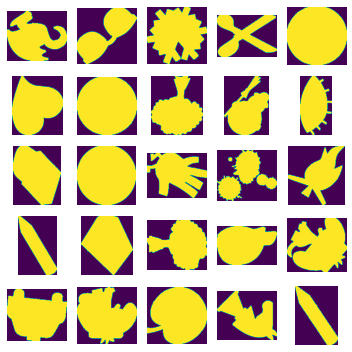

In [40]:
i = 0
plt.figure(figsize=(5, 5))
for p in random.sample(xtrainpaths, 25):
    img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    shape = extract_shape(img).reshape(img.shape).astype(np.uint) * 255
    plt.subplot(5, 5, i + 1)
    plt.imshow(shape)
    plt.axis("off")
    i += 1
plt.tight_layout()
plt.show()

To overcome this issue, there are some other techniques such as the image moments, and its variant, the Hu moments, that can also be implemented.

---
## Image Moments <a class="anchor" id="ImageMoments"></a>

Image moments are a great way to describe an image no matter its size or orientation. To implement it, we decided to follow its [wikipedia page](https://en.wikipedia.org/wiki/Image_moment).

#### Raw Moments<a class="anchor" id="ImageMomentsRaw"></a>
For a 2D continuous function f(x,y) the moment (sometimes called "raw moment") of order (p + q) is defined as:

$$M_{pq} = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} x^py^qf(x,y)\,dx\,dy$$

for p,q = 0,1,2,... Adapting this to scalar (greyscale) image with pixel intensities $I(x,y)$, raw image moments $M_{ij}$ are calculated by:

$$M_{ij} = \sum_{x}\sum_{y} x^iy^jI(x, y) $$

In [41]:
def raw_moments(img, order=3):
    moments = {}
    y, x = np.mgrid[:img.shape[0], :img.shape[1]]
    for j in range(order + 1):
        for i in range(order + 1):
            if i + j <= order:
                moments[f"m{i}{j}"] = np.float64(np.sum(x ** i * y ** j * img))
    return moments

#### Central Moments<a class="anchor" id="ImageMomentsCentral"></a>

For a 2D continuous function f(x,y) , central moments are defined as:
$$\mu _{{pq}}=\int \limits _{{-\infty }}^{{\infty }}\int \limits _{{-\infty }}^{{\infty }}(x-{\bar  {x}})^{p}(y-{\bar  {y}})^{q}f(x,y)\,dx\,dy$$ 
$\bar{x}={\frac {M_{10}}{M_{00}}}$ and $\bar{y}={\frac {M_{01}}{M_{00}}}$ being the components of the centroid.

If $I(x, y)$ is a digital image, then the previous equation becomes

$$\mu _{ij}=\sum _{x}\sum _{y}(x-{\bar {x}})^{i}(y-{\bar {y}})^{j}I(x,y)$$

Central moments are **translational invariant**.

In [42]:
def central_moments(img, raw, moments={}, order=3):
    y, x = np.mgrid[:img.shape[0], :img.shape[1]]

    centroidx = raw["m10"] / raw["m00"]
    centroidy = raw["m01"] / raw["m00"]

    for j in range(order + 1):
        for i in range(order + 1):
            if i + j <= order and (i + j > 1):  #mu01 = mu10 = 0 #mu00 = m00
                moments[f"mu{i}{j}"] = np.float64(np.sum((x - centroidx) ** i * (y - centroidy) ** j * img))
    return moments

#### Central Normalized Moments<a class="anchor" id="ImageMomentsNormalized"></a>
Invariants $\eta_{ij}$ with respect to both translation and scale can be constructed from central moments by dividing through a properly scaled zero-th central moment:

$$\eta _{ij}={\frac {\mu _{ij}}{\mu _{00}^{\left(1+{\frac {i+j}{2}}\right)}}}$$
where i + j ≥ 2. Note that translational invariance directly follows by only using central moments.

In [43]:
def central_normalized_moments(img, m00, central, moments={}, order=3):
    y, x = np.mgrid[:img.shape[0], :img.shape[1]]
    for j in range(4):
        for i in range(4):
            if i + j >= 2 and i + j <= order:
                moments[f"nu{i}{j}"] = np.float64(central[f"mu{i}{j}"] / m00 ** (1 + (i + j) / 2))
    return moments

In [44]:
def moments(imginv):  # Regroups all the moments in one dict
    raw = raw_moments(imginv)
    central = central_moments(imginv, raw, raw)
    central_normal = central_normalized_moments(imginv, raw["m00"], central, central)
    return central_normal

#### Hu Invariants<a class="anchor" id="ImageMomentsHu"></a>
As shown in the work of Hu, invariants with respect to translation, scale, and rotation can be constructed as the following:

$I_{1}=\eta _{{20}}+\eta _{{02}}$

$I_{2}=(\eta _{{20}}-\eta _{{02}})^{2}+4\eta _{{11}}^{2}$

$I_{3}=(\eta _{{30}}-3\eta _{{12}})^{2}+(3\eta _{{21}}-\eta _{{03}})^{2}$

$I_{4}=(\eta _{{30}}+\eta _{{12}})^{2}+(\eta _{{21}}+\eta _{{03}})^{2}$

$I_{5}=(\eta _{{30}}-3\eta _{{12}})(\eta _{{30}}+\eta _{{12}})[(\eta _{{30}}+\eta _{{12}})^{2}-3(\eta _{{21}}+\eta _{{03}})^{2}]+(3\eta _{{21}}-\eta _{{03}})(\eta _{{21}}+\eta _{{03}})[3(\eta _{{30}}+\eta _{{12}})^{2}-(\eta _{{21}}+\eta _{{03}})^{2}]$

$I_{6}=(\eta _{{20}}-\eta _{{02}})[(\eta _{{30}}+\eta _{{12}})^{2}-(\eta _{{21}}+\eta _{{03}})^{2}]+4\eta _{{11}}(\eta _{{30}}+\eta _{{12}})(\eta _{{21}}+\eta _{{03}})$

$I_{7}=(3\eta _{{21}}-\eta _{{03}})(\eta _{{30}}+\eta _{{12}})[(\eta _{{30}}+\eta _{{12}})^{2}-3(\eta _{{21}}+\eta _{{03}})^{2}]-(\eta _{{30}}-3\eta _{{12}})(\eta _{{21}}+\eta _{{03}})[3(\eta _{{30}}+\eta _{{12}})^{2}-(\eta _{{21}}+\eta _{{03}})^{2}].$

In [45]:
def hu_invariants_raw(cnm):  # Hu invariants based on the formulas above
    hu = np.array([
        cnm["nu20"] + cnm["nu02"],
        (cnm["nu20"] - cnm["nu02"]) ** 2 + 4 * cnm["nu11"] ** 2,
        (cnm["nu30"] - 3 * cnm["nu12"]) ** 2 + (3 * cnm["nu21"] - cnm["nu03"]) ** 2,
        (cnm["nu30"] + cnm["nu12"]) ** 2 + (cnm["nu21"] - cnm["nu03"]) ** 2,
        (cnm["nu30"] - 3 * cnm["nu12"]) * (cnm["nu30"] + cnm["nu12"])
        * ((cnm["nu30"] + cnm["nu12"]) ** 2 - 3 * (cnm["nu21"] + cnm["nu03"]) ** 2)
        + (3 * cnm["nu21"] - cnm["nu03"]) * (cnm["nu21"] + cnm["nu03"])
        * (3 * (cnm["nu30"] + cnm["nu12"]) ** 2 - (cnm["nu21"] + cnm["nu03"]) ** 2),
        (cnm["nu20"] - cnm["nu02"]) * ((cnm["nu30"] + cnm["nu12"]) ** 2 - (cnm["nu21"] + cnm["nu03"]) ** 2)
        + 4 * cnm["nu11"] * (cnm["nu30"] + cnm["nu12"]) * (cnm["nu21"] + cnm["nu03"]),
        (3 * cnm["nu21"] - cnm["nu03"]) * (cnm["nu30"] + cnm["nu12"])
        * ((cnm["nu30"] + cnm["nu12"]) ** 2 - 3 * (cnm["nu21"] + cnm["nu03"]) ** 2)
        - (cnm["nu30"] - 3 * cnm["nu12"]) * (cnm["nu21"] + cnm["nu03"])
        * (3 * (cnm["nu30"] + cnm["nu12"]) ** 2 - (cnm["nu21"] + cnm["nu03"]) ** 2)
    ])
    return hu

In order to check the results, we can compare them with the values generated by opencv's moments.

In [46]:
def test_moments(imgpath='trainset/train/05/c01_s04.png', threshold=0.002):
    print(f"Test.ing for moments with {threshold} threshold.")
    img = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
    imginv = cv2.bitwise_not(img)

    mom_ref = cv2.moments(imginv)
    mom = moments(imginv)

    count = 0
    invalid = []
    for k in mom_ref.keys():
        if abs(mom_ref[k] - mom[k]) < threshold:
            count += 1
        else:
            invalid.append(k)

    print(f"[{count}/{len(mom_ref)}] {count / len(mom_ref) * 100}% success")
    if count != len(mom_ref):
        print("\nINVALID at:")
        for i in invalid:
            print(f"{i}: {abs(mom_ref[i] - mom[i])} > threshold({threshold}).")


def test_hu(imgpath='trainset/train/05/c01_s04.png', threshold=0.002):
    print(f"Test.ing for hu invariants with {threshold} threshold.")
    img = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
    imginv = cv2.bitwise_not(img)
    mom_ref = cv2.moments(imginv)
    mom = moments(imginv)

    hui_ref = cv2.HuMoments(mom_ref)
    hui = hu_invariants_raw(mom)

    count = 0
    invalid = []
    for i in range(len(hui_ref)):
        if abs(hui_ref[i][0] - hui[i]) < threshold:
            count += 1
        else:
            invalid.append(i)

    print(f"[{count}/{len(hui_ref)}] {count / len(hui_ref) * 100}% success")
    if count != len(hui_ref):
        print("\nINVALID at:")
        for i in invalid:
            print(f"I{i}: {abs(hui_ref[i][0] - hui[i])} > threshold({threshold}).")

In [47]:
test_moments(threshold=0.01)
print()
test_moments(threshold=0.0001)
print()
test_hu(threshold=0.0000000001)

Test.ing for moments with 0.01 threshold.
[17/24] 70.83333333333334% success

INVALID at:
m20: 90194313216.0 > threshold(0.01).
m11: 55834574848.0 > threshold(0.01).
m02: 51539607552.0 > threshold(0.01).
m30: 17441862189056.0 > threshold(0.01).
m21: 9766755631104.0 > threshold(0.01).
m12: 7468948127744.0 > threshold(0.01).
m03: 7267084664832.0 > threshold(0.01).

Test.ing for moments with 0.0001 threshold.
[14/24] 58.333333333333336% success

INVALID at:
m20: 90194313216.0 > threshold(0.0001).
m11: 55834574848.0 > threshold(0.0001).
m02: 51539607552.0 > threshold(0.0001).
m30: 17441862189056.0 > threshold(0.0001).
m21: 9766755631104.0 > threshold(0.0001).
m12: 7468948127744.0 > threshold(0.0001).
m03: 7267084664832.0 > threshold(0.0001).
mu30: 0.0001220703125 > threshold(0.0001).
mu21: 0.0011749267578125 > threshold(0.0001).
mu12: 0.000335693359375 > threshold(0.0001).

Test.ing for hu invariants with 1e-10 threshold.
[7/7] 100.0% success


As we can see, the results are very closely similar. Although central moments tend to vary a little bit, the resulting hu invariants remain very similar.
**These results allow us to validate our Hu Moments implementation.**

All of this allows us to create the following function that gives us the Hu Moments of an image given its path.

In [48]:
def hu_from_path_raw(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Open image in grayscale
    imginv = cv2.bitwise_not(img)  # Invert colors
    mom = moments(imginv)
    hu = hu_invariants_raw(mom)
    return hu

### Evaluating the results : The importance of normalizing the data<a class="anchor" id="ImageMomentsEval"></a>
Although Hu moments are very effective at describing an image no matter its scale or orientation, the difference in magnitude can render the data, and thus the training, less effective.
To avoid this, we can normalize the results using the following log transform as described **[here](https://learnopencv.com/shape-matching-using-hu-moments-c-python/)**.

$$H_i = - \text{sign}(h_i) \log | h_i |$$

In [49]:
 def hu_invariants(cnm):  # Apply the normalizing formula above on the raw Hu invariants
    return np.array([-1 * math.copysign(1.0, i) * math.log10(abs(i)) for i in hu_invariants_raw(cnm)])

In [50]:
def hu_from_path_norm(path):  # Compute normalized Hu Moments of an image given its path.
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Open image in grayscale
    imginv = cv2.bitwise_not(img)  # Invert colors
    mom = moments(imginv)
    hu = hu_invariants(mom)
    return hu

The following shows us how normalization affects the results.

In [51]:
xtrain_raw = get_data(xtrainpaths, hu_from_path_raw)
xtest_raw = get_data(xtestpaths, hu_from_path_raw)
print("Raw Hu moments\t\t", end='')
my_test(xtrain_raw, ytrain, xtest_raw, ytest)

xtrain = get_data(xtrainpaths, hu_from_path_norm)
xtest = get_data(xtestpaths, hu_from_path_norm)
print("Normalized Hu moments\t", end='')
my_test(xtrain, ytrain, xtest, ytest)

Raw Hu moments		80.70175438596492   % success
Normalized Hu moments	98.24561403508771   % success


As we can see, the normalization enhances the results by a significant amount. From now on, we will thus use the **normalized Hu Moments**.

---

## Color Histograms <a class="anchor" id="ColorHistograms"></a>

Another obvious feature we can use is the color histogram. As the symbols as always the same, their color histograms should also be identical, which means it should be very effective.

If we simply use the image as is, our data might be noisy from the white background. To avoid this, we can use a mask.
In order to to this, we can use the previously presented shape extractor (aka the extract_shape function) that was not deemed as very useful.

**We don't want to compute a full histogram with all the different colors**, as it would be **too long and too heavy**. In order to avoid that, we can try to **reduce the data**, here the colors.

To do that, we will be using **kmeans clustering** to determine the "color groups": we go over a sample of images, and in this image sample, pick a certain amount of random pixels that constitue our training data based on which we set up our kmeans clustering.

Since there are approximately 10 different colors in the Dobble symbols, we decided to make **10 clusters**.

In [52]:
def select_rng_pixels(imageList):
    random_seed = 3
    rng = np.random.default_rng(random_seed)
    sample_img = rng.choice(imageList, size=40, axis=0)
    pixels = []
    for img in sample_img:
        image = cv2.imread(img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        w, h, p = image.shape
        sample_image = image.reshape(w * h, p)  # "Flatten" the image shape, basically a list of pixels
        sample_pixels = rng.choice(sample_image, size=500, axis=0)  # Pick 500 random pixels among the image's pixels
        for p in sample_pixels:
            pixels.append(p)
    return pixels


rng_pixels = select_rng_pixels(xtrainpaths)
global kmeans10
kmeans10 = KMeans(n_clusters=10).fit(rng_pixels)

array([[ 26,  25,  24],
       [253, 254, 254],
       [148,  37,  25],
       [247, 171,  70],
       [ 85, 178, 241],
       [223,  43,  39],
       [195, 193, 186],
       [ 75,  49,  29],
       [ 91, 123,  49],
       [111,  87, 119]], dtype=uint8)

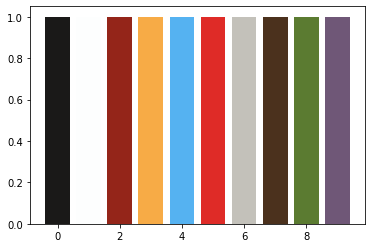

In [53]:
color_lut = np.uint8(kmeans10.cluster_centers_)
plt.bar(np.arange(len(color_lut)),
         np.ones(len(color_lut)),
         color=color_lut/255)
color_lut

From then on, we juste need to pass the image's data that went through the shape mask, and get the color histogram we get from the kmeans results.

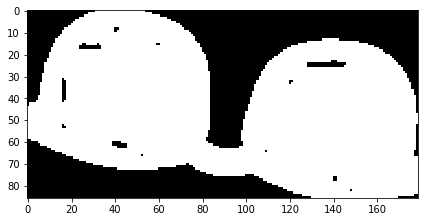

In [54]:
image_path = 'trainset/train/01/c01_s00.png'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
back_ground = extract_shape(image)[..., 0] > 0
io.imshow(back_ground)

In [55]:
def get_histo(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    back_ground = extract_shape(image)[..., 0] > 0
    label_map = kmeans10.predict(image[back_ground])
    bb_hist = np.bincount(label_map, minlength=kmeans10.n_clusters) / np.count_nonzero(back_ground)
    return np.array(bb_hist).reshape(-1)

### Third Feature : BRIEF Algorithm <a class="anchor" id="ColorHistogramsEval"></a>
A Fast descriptor algorithm which compute an array of byte base on the intensity of a certain point

In [56]:
def get_centers(points):
    centers = []
    i = 0
    ray = 15
    points_size = len(points)
    while i in range(points_size):
        circle_x, circle_y = points[i]
        centers.append((circle_x, circle_y))
        points = remove_point_in_circle(circle_x, circle_y, points, ray * 2) # we remove all the point with in the circle
        points_size = len(points)
        i += 1
    return centers

def remove_point_in_circle(x, y, L, diam):
    len1 = len(L)
    i = 0
    while i in range((len1)):
        x_pos, y_pos = L[i]
        if in_circle(x_pos, y_pos, diam, x, y):
            L.pop(i)
            len1 = len(L)
        i += 1
    return L

def in_circle(x, y, ray, circle_x, circle_y):
    return (x - circle_x) * (x - circle_x) + (y - circle_y) * (y - circle_y) <= (ray * ray)

In [57]:
def get_image_in_gray(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def get_shape_edges(shape):
    return filters.sobel(shape)

def get_edges(shapes):
    edges = []
    for shape in shapes:
        edges.append(get_shape_edges(shape))
    return edges

def get_white_pixels(image, width, height):
    image.reshape(width, height)
    white_pixels = []
    for i in range(len(image)):
        for j in range(len(image[0])):
            if image[i][j] != 0.0:
                white_pixels.append((i, j))
    return white_pixels

def extract_shape(image):
    sobel = filters.sobel(image)
    res = ndi.binary_fill_holes(sobel)
    return res

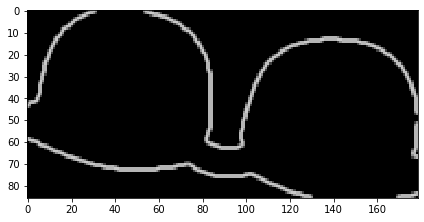

In [58]:
from skimage import io, measure, filters, segmentation, feature, morphology
from scipy import ndimage as ndi

image_test_path = 'trainset/train/01/c01_s00.png'
new_size_image = get_image_in_gray(image_test_path)
image_gray = cv2.cvtColor(new_size_image, cv2.COLOR_BGR2GRAY)
edges = get_shape_edges(extract_shape(io.imread(image_test_path, as_gray=True))) # we will compute the brief algorithm on the edges of the image
w, h = edges.shape
io.imshow(edges)

In [60]:
def show_centers(image, centers):
    for center in centers:
        x,y = center
        image[x][y][0] = 1
        image[x][y][0], image[x][y][0] = 0, 0
    return image

def get_image_in_colors(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

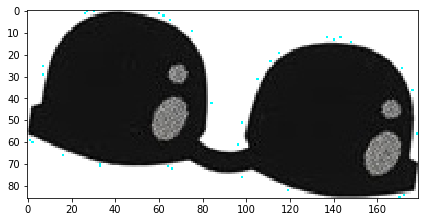

In [61]:
centers = get_centers(get_white_pixels(edges, h, w))
img_color = get_image_in_colors(image_test_path)

io.imshow(show_centers(img_color, centers))

In [ ]:
def compute_string(M, x, y):
    s = []
    if (M[x - 1][y - 1] < M[x + 1][y + 1]):
        s.append(1)
    else:
        s.append(0)
    if (M[x + 1][y - 1] < M[x - 1][y + 1]):
        s.append(1)
    else:
        s.append(0)
    if (M[x][y - 1] < M[x][y + 1]):
        s.append(1)
    else:
        s.append(0)
    if (M[x - 1][y] < M[x + 1][y]):
        s.append(1)
    else:
        s.append(0)
    return s

In [ ]:
def compute_brief_on_image(img_path):
    n = 30 # we applied the BRIEF algorithm on 30 random points
    new_size_image = get_image_in_gray(img_path)
    image_gray = cv2.cvtColor(new_size_image, cv2.COLOR_BGR2GRAY)
    edges = get_shape_edges(extract_shape(io.imread(img_path, as_gray=True)))
    w, h = edges.shape
    centers = get_centers(get_white_pixels(edges, w, h))
    value_of_evaluation = []
    for c in centers :
        x, y = c
        if x < w -1 and y < h - 1:
            value_of_evaluation.append(compute_string(image_gray, x, y))
    value_of_evaluation = np.random.default_rng().choice(value_of_evaluation, size=n, axis=0)
    return np.array(value_of_evaluation).flatten()

In [ ]:
def xor_on_hist(A, B):
    res = 0
    for i in range(len(A)):
        res += A[i] ^ B[i] # as bytes array the XOR result is enough
    return res

def get_distance(histo1, histo2):
    return xor_on_hist(histo1, histo2) # compute the distance between to histograms

def getPredicted(histo, histograms):
    res, pos = get_distance(histo, histograms[0]), 0
    for i in range(len(histograms)):
        tmp_res = get_distance(histo, histograms[i])
        if tmp_res < res:
            res, pos = tmp_res, i
    return pos + 1


def compute_brief(image_path, kmeans):
    predict = compute_brief_on_image(image_path)
    predict = np.reshape(predict, (1, len(predict)))
    label_map = kmeans.predict(predict)
    return np.bincount(label_map, minlength=kmeans.n_clusters)

In [ ]:
from dir.dir import getImagesFromTrainset

def get_pixels(trainSetPath):
    imageList, _ = getImagesFromTrainset(trainSetPath)
    rng = np.random.default_rng()
    sample_img = rng.choice(imageList, size=15, axis=0)
    pixels = []
    for img in sample_img:
        flatten = np.array(compute_brief_on_image(img)).flatten()
        pixels.append(flatten)
    return pixels

In [ ]:
train_set_path = 'trainset/train/'
pixels = get_pixels(train_set_path)

kmeansBrief = KMeans(n_clusters=8).fit(pixels)

In [ ]:
imageList, expectedClass = getImagesFromTrainset(train_set_path)
test_set, test_res, train_set, train_res = [], [], [], []
data_len = len(imageList)
sample = set(random.sample(range(data_len), data_len * 20 // 100))
for i in range(data_len):
    if i in sample:
        test_set.append(imageList[i])
        test_res.append(expectedClass[i])
    else:
        train_set.append(imageList[i])
        train_res.append(expectedClass[i])

In [ ]:
hists = [compute_brief(p, kmeansBrief) for p in test_set]
hists = np.array(hists)
hists.reshape(len(test_set), -1)

good, bad = 0, 0
for i in range(len(test_set)):
    h = compute_brief(test_set[i], kmeansBrief)
    predictedClass = getPredicted(h, hists)
    if predictedClass == test_res[i]:
        good += 1
    else:
        bad += 1

good, bad

### Evaluating the results <a class="anchor" id="ColorHistogramsEval"></a>
A basic way to evaluate the results is to pass the computed histograms of our training set into a random forest classifier, using the "my_test" function.

In [ ]:
xtrain_col = get_data(xtrainpaths, get_histo)
xtest_col = get_data(xtestpaths, get_histo)

my_test(xtrain_col, ytrain, xtest_col, ytest)

As we can see, the results are **very satisfying**, with only the color histograms.

---

## Evaluating and comparing the results<a class="anchor" id="Evaluate"></a>
To simply score the data, we chose to stick to a binary success rate as the given exercise is a basic one that ca simply be evaluated by counting success count over total predictions. We will use this scoring method to chose the best fitting classifier.

We first looked into different types of classifiers, and then decided to juste try a lot of different ones to see the results.

In [ ]:
def preprocess(paths, feature_extractors):
    # Compute and fuse given features from the feature_extractors list from given image paths
    features = get_data(paths, feature_extractors[0])
    return features


def preprocess_all(trnx, trny, tstx, tsty, extractors):
    return preprocess(trnx, extractors), trny, preprocess(tstx, extractors), tsty

In [ ]:
def testset_test(clf, data, expected, display=False):
    # Returns Success Rate, True, False, Test set size
    false = 0
    for i in range(len(data)):
        res = clf.predict(data[i].reshape(1, -1))[0]
        if res != expected[i]:
            false += 1
            if display: print(f"{str(i + 1).zfill(2)}: expected {expected[i]}, but got {str(res).zfill(2)}.")
    return (1 - false / len(data)) * 100, len(data) - false, false, len(data)


def test_classifiers(xtrain, ytrain, xtest, ytest):
    results = [[*testset_test(RandomForestClassifier().fit(xtrain, ytrain), xtest, ytest), "RandomForestClassifier"],
               [*testset_test(GaussianNB().fit(xtrain, ytrain), xtest, ytest), "GaussianNB"],
               [*testset_test(DecisionTreeClassifier().fit(xtrain, ytrain), xtest, ytest), "DecisionTreeClassifier"],
               [*testset_test(NearestCentroid().fit(xtrain, ytrain), xtest, ytest), "NearestCentroid"],
               [*testset_test(KNeighborsClassifier().fit(xtrain, ytrain), xtest, ytest), "KNeighborsClassifier"],
               [*testset_test(LogisticRegression(max_iter=500).fit(xtrain, ytrain), xtest, ytest),
                "LogisticRegression"],
               [*testset_test(LinearSVC().fit(xtrain, ytrain), xtest, ytest), "LinearSVC"],
               [*testset_test(RidgeClassifier().fit(xtrain, ytrain), xtest, ytest), "RidgeClassifier"],
               [*testset_test(MLPClassifier().fit(xtrain, ytrain), xtest, ytest), "MLPClassifier"],
               [*testset_test(random_clf, xtest, ytest), "Random"]]

    return results

In [ ]:
def full_test(data_dir='trainset/train'):
    def display_results(results):
        print("{:<20} {:<8} {:<8} {:<8} {:<20}".format("Success Rate", "True", "False", "Total", "Classifier"))
        print('-' * 20, '-' * 8, '-' * 8, '-' * 8, '-' * 20)
        for row in results:
            print("{:<20} {:<8} {:<8} {:<8} {:<20}".format(*row))

    trainx, trainy, testx, testy = get_imgs_paths(data_dir)

    print("Hu moments")
    hu_test = test_classifiers(
        *preprocess_all(trainx, trainy, testx, testy, [hu_from_path_norm]))  #No fusion, only hu moments
    display_results(hu_test)
    print()

    print("Color Histogram")
    col_test = test_classifiers(
        *preprocess_all(trainx, trainy, testx, testy, [get_histo]))  #No fusion, only color histogram
    display_results(col_test)
    print()

In [ ]:
## To get a clear result 
save = full_test()

---

## Improving the results : Feature Fusion <a class="anchor" id="Improve"></a>
As we are using multiple features, it can be interesting to use feature fusion. As our features on their own are already effective enough, a simple fusion by concatenation will suffice.

In [ ]:
def fuse_features(features):
    return np.concatenate(tuple(features), axis=1)

In [ ]:
def preprocess(paths, feature_extractors):
    # Compute and fuse given features from the feature_extractors list from given image paths
    features = [get_data(paths, extract) for extract in feature_extractors]
    data = fuse_features(features)
    return data

We can now redefine the full_test function to also take into account the feature fusion we just talked about.

In [ ]:
def full_test(data_dir='trainset/train'):
    def display_results(results):
        print("{:<20} {:<8} {:<8} {:<8} {:<20}".format("Success Rate", "True", "False", "Total", "Classifier"))
        print('-' * 20, '-' * 8, '-' * 8, '-' * 8, '-' * 20)
        for row in results:
            print("{:<20} {:<8} {:<8} {:<8} {:<20}".format(*row))

    trainx, trainy, testx, testy = get_imgs_paths(data_dir)

    print("Hu moments")
    hu_test = test_classifiers(
        *preprocess_all(trainx, trainy, testx, testy, [hu_from_path_norm]))  #No fusion, only hu moments
    display_results(hu_test)
    print()

    print("Color Histogram")
    col_test = test_classifiers(
        *preprocess_all(trainx, trainy, testx, testy, [get_histo]))  #No fusion, only color histogram
    display_results(col_test)
    print()

    print("Color histogram & Hu moments simple fusion")
    hucol_test = test_classifiers(
        *preprocess_all(trainx, trainy, testx, testy, [hu_from_path_norm, get_histo]))  #Fusion, hu moments + histograms
    display_results(hucol_test)

In [ ]:
## To get a clear result 
save = full_test()

---

## Results analysis<a class="anchor" id="Results"></a>
The previous results show how Hu moments on their own can be good enough. However, after some extensive testing, **Hu Moments are only perfectly effective half of the time** (but still close to perfection).

Although **color histograms are showing some very satisfying results**, we still aren't getting perfect results.

This is why we chose to use **feature fusion**, which clearly reinforced our results.

As for the classifier, the **Random Forest Classifier** is the clear winner, as it gives us perfect predictions. This observation is normal considering random forests are better suited for multiclass classification, with leaf nodes that can refer to any of the K classes concerned, and the multiplicity of trees (as it is a forest) allows us to reinforce the results.

Please note that the Gaussian Naive Bayes also produces some nice results.

In [ ]:
trainx, trainy, testx, testy = preprocess_all(*get_imgs_paths(trainpath), [hu_from_path_norm, get_histo])
best_clf = RandomForestClassifier().fit(trainx, trainy)

Another way to improve our project would be to fiddle with the meta parameters. Unfortunately, we didn't have enough time left to look into it.

In [ ]:
best_clf.get_params()

We can also use sklearn scoring functions, but since the results are perfect, there isn't much point in using it...

In [ ]:
y_pred = np.array([best_clf.predict(x.reshape(1, -1)) for x in testx])
score_per_class = f1_score(testy, y_pred, average=None)
global_score = f1_score(testy, y_pred, average='micro')

In [ ]:
print(f"global_score:\t\t {global_score}.")

---

## Conclusion<a class="anchor" id="Conclusion"></a>

All in all, we managed to create a classifier that can confidently infer the type of a Dobble symbol with (close to) perfect accuracy.

### Save the model !
You can use the following to save the mode to avoid training it again.

In [ ]:
def save_model(model):
    joblib_file = "zodinx.pkl"
    joblib.dump(model, joblib_file)


save_model(best_clf)


def load_model():
    joblib_file = "zodinx.pkl"
    bis = joblib.load(joblib_file)
    return bis


testset_test(load_model(), testx, testy)

We can now redefine the full_test function to also take into account the feature fusion we just talked about.

In [ ]:
def full_test(data_dir='trainset/train'):
    def display_results(results):
        print("{:<20} {:<8} {:<8} {:<8} {:<20}".format("Success Rate", "True", "False", "Total", "Classifier"))
        print('-' * 20, '-' * 8, '-' * 8, '-' * 8, '-' * 20)
        for row in results:
            print("{:<20} {:<8} {:<8} {:<8} {:<20}".format(*row))

    trainx, trainy, testx, testy = get_imgs_paths(data_dir)

    print("Hu moments")
    hu_test = test_classifiers(
        *preprocess_all(trainx, trainy, testx, testy, [hu_from_path_norm]))  #No fusion, only hu moments
    display_results(hu_test)
    print()

    print("Color Histogram")
    col_test = test_classifiers(
        *preprocess_all(trainx, trainy, testx, testy, [get_histo]))  #No fusion, only color histogram
    display_results(col_test)
    print()

    print("Color histogram & Hu moments simple fusion")
    hucol_test = test_classifiers(
        *preprocess_all(trainx, trainy, testx, testy, [hu_from_path_norm, get_histo]))  #Fusion, hu moments + histograms
    display_results(hucol_test)

In [ ]:
## To get a clear result 
save = full_test()

---

## Results analysis<a class="anchor" id="Results"></a>
The previous results show how Hu moments on their own can be good enough. However, after some extensive testing, **Hu Moments are only perfectly effective half of the time** (but still close to perfection).

Although **color histograms are showing some very satisfying results**, we still aren't getting perfect results.

This is why we chose to use **feature fusion**, which clearly reinforced our results.

As for the classifier, the **Random Forest Classifier** is the clear winner, as it gives us perfect predictions. This observation is normal considering random forests are better suited for multiclass classification, with leaf nodes that can refer to any of the K classes concerned, and the multiplicity of trees (as it is a forest) allows us to reinforce the results.

Please note that the Gaussian Naive Bayes also produces some nice results.

In [ ]:
trainx, trainy, testx, testy = preprocess_all(*get_imgs_paths(trainpath), [hu_from_path_norm, get_histo])
best_clf = RandomForestClassifier().fit(trainx, trainy)

Another way to improve our project would be to fiddle with the meta parameters. Unfortunately, we didn't have enough time left to look into it.

In [ ]:
best_clf.get_params()

We can also use sklearn scoring functions, but since the results are perfect, there isn't much point in using it...

In [ ]:
y_pred = np.array([best_clf.predict(x.reshape(1, -1)) for x in testx])
score_per_class = f1_score(testy, y_pred, average=None)
global_score = f1_score(testy, y_pred, average='micro')

In [ ]:
print(f"global_score:\t\t {global_score}.")

---

## Conclusion<a class="anchor" id="Conclusion"></a>

All in all, we managed to create a classifier that can confidently infer the type of a Dobble symbol with (close to) perfect accuracy.

### Save the model !
You can use the following to save the mode to avoid training it again.

In [ ]:
def save_model(model):
    joblib_file = "zodinx.pkl"
    joblib.dump(model, joblib_file)


save_model(best_clf)


def load_model():
    joblib_file = "zodinx.pkl"
    bis = joblib.load(joblib_file)
    return bis


testset_test(load_model(), testx, testy)

In [ ]:
joblib.dump(kmeans10, 'kmeans.pkl')